# Titanic dataset Classification using Decision Trees
## by Alejandro Puerto Castro

In [1]:
# linear algebra
import numpy as np 

# data processing
import pandas as pd 

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import pydotplus
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

# Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import confusion_matrix

# 1. Impurity Indices (measures)

In [2]:
def entropy(p):
   return - p*np.log2(p) - (1 - p)*np.log2((1 - p))

def gini(p):
   return (p)*(1 - (p)) + (1 - p)*(1 - (1-p))

def classification_error(p):
   return 1 - np.max([p, 1 - p])

In [3]:
x = np.arange(0.0, 1.0, 0.01)
ent = [entropy(p) if p != 0 else None for p in x]
scaled_ent = [e*0.5 if e else None for e in ent]
c_err = [classification_error(i) for i in x]

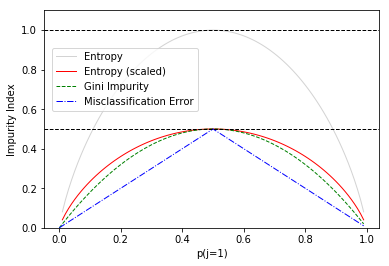

In [4]:
fig = plt.figure()
ax = plt.subplot(111)

for j, lab, ls, c, in zip(
      [ent, scaled_ent, gini(x), c_err],
      ['Entropy', 'Entropy (scaled)', 'Gini Impurity', 'Misclassification Error'],
      ['-', '-', '--', '-.'],
      ['lightgray', 'red', 'green', 'blue']):
   line = ax.plot(x, j, label=lab, linestyle=ls, lw=1, color=c)

ax.legend(loc='upper left', bbox_to_anchor=(0.01, 0.85),
         ncol=1, fancybox=True, shadow=False)

ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')

plt.ylim([0, 1.1])
plt.xlabel('p(j=1)')
plt.ylabel('Impurity Index')
plt.show()

# 2. Preprocessing steps

In [5]:
train_df = pd.read_csv("train.csv")

In [6]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
train_df_new = train_df.drop(['Ticket', 'Cabin'], axis = 1)

In [9]:
train_df_new.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


In [10]:
train_df_new.dropna(inplace = True)

In [11]:
train_df_new.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

# 3. Data Exploration

In [12]:
train_df_new.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


In [13]:
(pd.crosstab(train_df_new['Survived'], train_df_new['Pclass'])/(train_df_new.shape[0]))*100

Pclass,1,2,3
Survived,,,
0,8.988764,12.640449,37.921348
1,16.853933,11.657303,11.938202


In [14]:
(pd.crosstab(train_df_new['Survived'], train_df_new['Sex'])/(train_df_new.shape[0]))*100

Sex,female,male
Survived,,
0,8.988764,50.561798
1,27.387640,13.061798


In [15]:
train_df_new.shape[0]

712

In [16]:
(pd.crosstab(train_df_new['Survived'], [train_df_new['Pclass'], train_df_new['Sex']])/(train_df_new.shape[0]))*100

Pclass            1                   2                    3           
Sex          female      male    female       male    female       male
Survived                                                               
0          0.421348  8.567416  0.842697  11.797753  7.724719  30.196629
1         11.235955  5.617978  9.550562   2.106742  6.601124   5.337079

# 4. Preparing the data

In [17]:
sex_dummy = pd.get_dummies(train_df_new['Sex'])

In [18]:
train_subset = pd.concat([train_df_new[['Survived', 'Pclass', 'Sex', 'Age']], sex_dummy], axis = 1)

In [19]:
train_subset.head()

,Survived,Pclass,Sex,Age,female,male
0,0,3,male,22.0,0,1
1,1,1,female,38.0,1,0
2,1,3,female,26.0,1,0
3,1,1,female,35.0,1,0
4,0,3,male,35.0,0,1


In [20]:
X = train_subset[['Pclass', 'Age', 'male']]
y = train_subset['Survived']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 1)

# 5. Decision Tree

In [22]:
def confusion_matrix_model(model):
    """
    Function to give a format to the confusion matrix
    """
    cm = confusion_matrix(y_test, model.predict(X_test))
    col=["Predicted Dead","Predicted Survived"]
    cm=pd.DataFrame(cm)
    cm.columns=["Predicted Dead","Predicted Survived"]
    cm.index=["Actual Dead","Actual Survived"]
    #cm[col]=np.around(cm[col].div(cm[col].sum(axis=1),axis=0),decimals=2) # For percentage
    return cm

## 5.1 Entropy Decision Tree

In [23]:
entropy_dec_tree = DecisionTreeClassifier(criterion = "entropy", max_depth = 5, min_samples_leaf=1)
entropy_dec_tree.fit(X_train, y_train)
entropy_dec_tree_pred = entropy_dec_tree.predict(X_test)

In [24]:
confusion_matrix_model(entropy_dec_tree)

,Predicted Dead,Predicted Survived
Actual Dead,94,32
Actual Survived,19,69


In [25]:
print("Entropy - Decision Tree's accuracy is %.4f" % entropy_dec_tree.score(X_test, y_test))

Entropy - Decision Tree's accuracy is 0.7617


## 5.2 Gini Index Decision Tree

In [26]:
gini_dec_tree = DecisionTreeClassifier(criterion = "gini", max_depth = 5, min_samples_leaf=1)
gini_dec_tree.fit(X_train, y_train)
gini_dec_tree_pred = gini_dec_tree.predict(X_test)

In [27]:
confusion_matrix_model(gini_dec_tree)

,Predicted Dead,Predicted Survived
Actual Dead,93,33
Actual Survived,19,69


In [28]:
print("Gini - Decision Tree's accuracy is %.4f" % gini_dec_tree.score(X_test, y_test))

Gini - Decision Tree's accuracy is 0.7570


### 5.c Entropy Decision Tree

In [29]:
best_dec_tree_entropy = export_graphviz(entropy_dec_tree, out_file = None, max_depth = 3, #max_depth is maximum number of levels in the tree
                              feature_names = X.columns,
                              class_names = ['Died', 'Survived'],
                              filled= True )

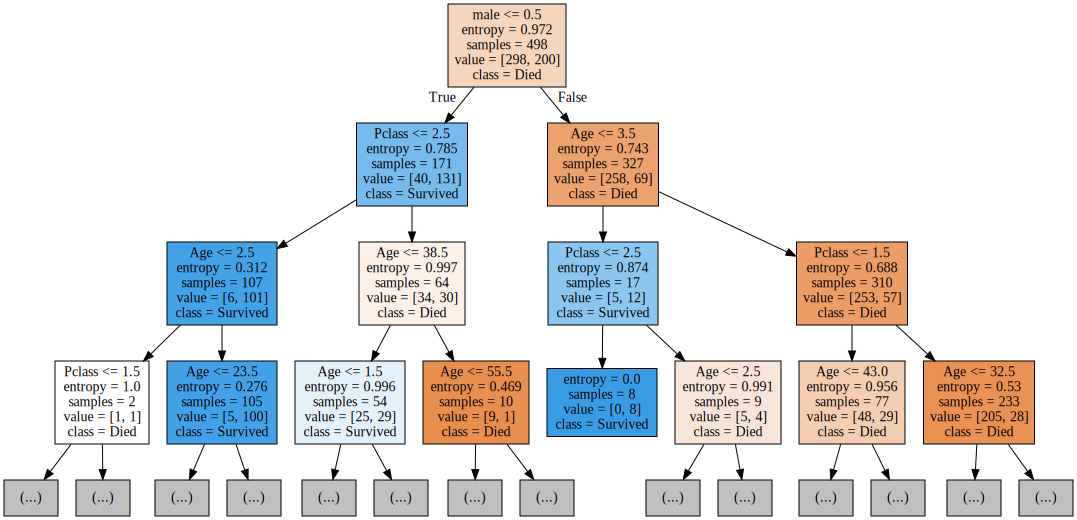

In [30]:
graph = graphviz.Source(best_dec_tree_entropy)
graph

### 5.c Gini Decision Tree

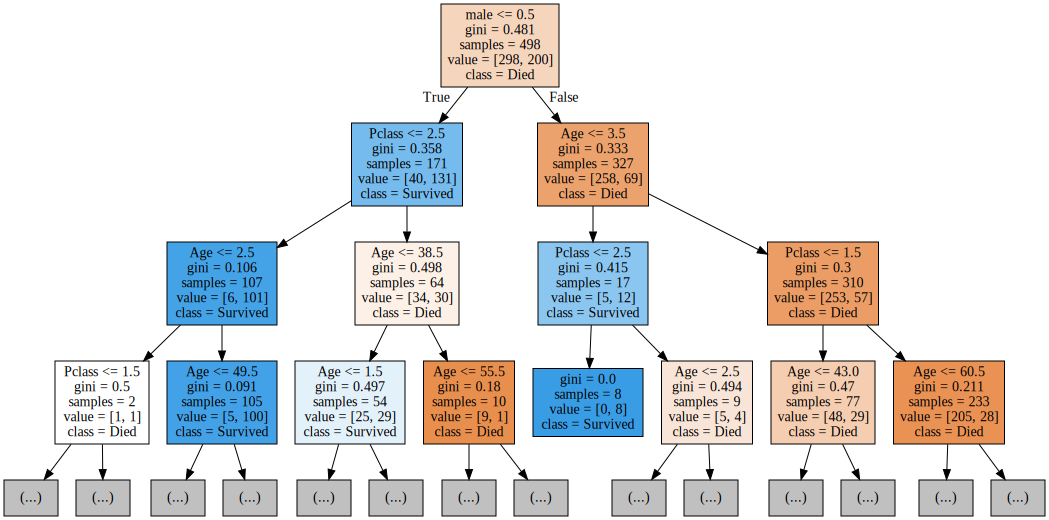

In [31]:
best_dec_tree_gini = export_graphviz(gini_dec_tree,out_file = None, max_depth = 3,
                              feature_names = X.columns,
                              class_names = ['Died', 'Survived'],
                              filled= True )
graph = graphviz.Source(best_dec_tree_gini)
graph

# 6. Selecting best values

In [32]:
depth_val = np.arange(2, 11)
leaf_val = np.arange(1, 31, step = 9)

grid_s = [{'max_depth': depth_val, 'min_samples_leaf': leaf_val}]

model = DecisionTreeClassifier(criterion = 'gini')

In [33]:
cv_tree = GridSearchCV(estimator = model, param_grid = grid_s, 
                       cv = KFold(n_splits = 10),
                               return_train_score = True
                      )

In [34]:
cv_tree.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]), 'min_samples_leaf': array([ 1, 10, 19, 28])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [35]:
best_depth = cv_tree.best_params_['max_depth']
best_min_leaf = cv_tree.best_params_['min_samples_leaf']

In [36]:
print("The best maximum number of  levels (depth) is %i" % best_depth)
print("The best minimum number of samples leaf is %i" % best_min_leaf)

The best maximum number of  levels (depth) is 3
The best minimum number of samples leaf is 10


In [37]:
cv_results = pd.DataFrame(cv_tree.cv_results_)
cv_results.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.003954,0.002142,0.000993,0.000631,2,1,"{'max_depth': 2, 'min_samples_leaf': 1}",0.76,0.7,0.82,...,0.801339,0.801339,0.803571,0.801339,0.799107,0.805804,0.806236,0.804009,0.803658,0.002683
1,0.003508,0.000680,0.000601,0.000491,2,10,"{'max_depth': 2, 'min_samples_leaf': 10}",0.76,0.7,0.82,...,0.801339,0.801339,0.803571,0.801339,0.799107,0.805804,0.806236,0.804009,0.803658,0.002683


In [38]:
cv_tree_results = cv_results[['param_max_depth', 'param_min_samples_leaf', 'mean_test_score']]
cv_tree_results.head()

,param_max_depth,param_min_samples_leaf,mean_test_score
0,2,1,0.781124
1,2,10,0.781124
2,2,19,0.769076
3,2,28,0.773092
4,3,1,0.797189


In [39]:
cv_tree_results_new = cv_tree_results.loc[:,['param_max_depth', 'param_min_samples_leaf']].apply(pd.to_numeric)

In [40]:
cv_tree_results = pd.concat((cv_tree_results.drop(['param_max_depth', 'param_min_samples_leaf'], axis=1), cv_tree_results_new), axis=1)

In [41]:
cv_tree_results.info() #Changed data type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 3 columns):
mean_test_score           36 non-null float64
param_max_depth           36 non-null int64
param_min_samples_leaf    36 non-null int64
dtypes: float64(1), int64(2)
memory usage: 944.0 bytes


[Text(33,0.5,'min_samples_leaf'), Text(0.5,15,'max_depth')]

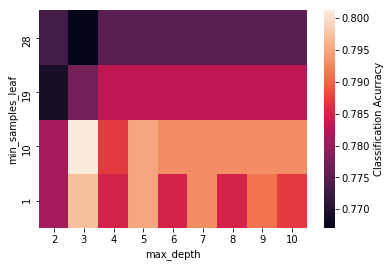

In [42]:
cv_tree_results = cv_tree_results.pivot('param_min_samples_leaf', 'param_max_depth', 'mean_test_score')

ax = sns.heatmap(cv_tree_results, cbar_kws={'label': 'Classification Acurracy'})
ax.invert_yaxis()
ax.set(xlabel = 'max_depth', ylabel = 'min_samples_leaf')

# 7. Testing Model

In [43]:
best_cv_tree = DecisionTreeClassifier(criterion  = 'entropy', max_depth = best_depth,
                                      min_samples_leaf = best_min_leaf)

In [44]:
best_cv_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [45]:
survive_pred = best_cv_tree.predict(X_test)

In [46]:
confusion_matrix_model(best_cv_tree)

,Predicted Dead,Predicted Survived
Actual Dead,104,22
Actual Survived,23,65


In [47]:
accuracy = best_cv_tree.score(X_test, y_test)
print("The accuracy of the model is %.4f" % accuracy)

The accuracy of the model is 0.7897


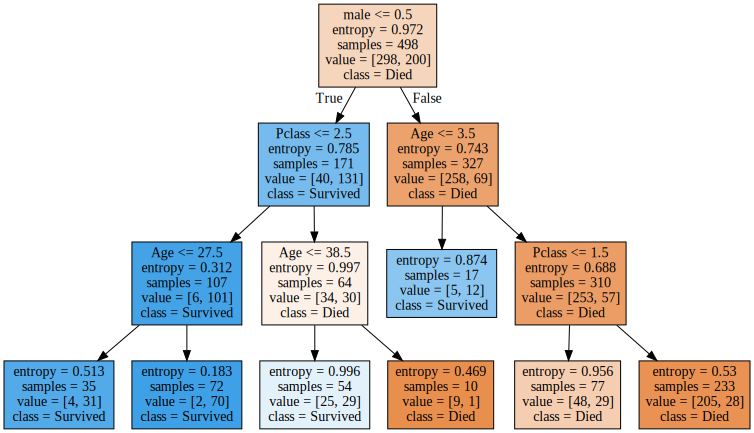

In [48]:
best_tree = export_graphviz(best_cv_tree,out_file = None, max_depth = 3,
                              feature_names = X.columns,
                              class_names = ['Died', 'Survived'],
                              filled= True )
graph = graphviz.Source(best_tree)
graph